#### Import lib

In [3]:
import os
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
import numpy as np
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

#### Get label

In [4]:
def get_emotion_label(filename):
    try:
        return filename.split('_')[1].split('.')[0]
    except IndexError:
        return None

#### Data Augmentation


In [ ]:
SAMPLE_RATE = 16000

def augment_audio(audio, sr=SAMPLE_RATE):
    # Change the speed of speech
    audio_speed_up = librosa.effects.time_stretch(audio, rate=1.2)
    audio_slow_down = librosa.effects.time_stretch(audio, rate=0.8)

    # Add white noise
    noise = np.random.randn(len(audio))
    audio_with_noise = audio + 0.005 * noise

    # Change Pitch
    audio_pitch_shifted = librosa.effects.pitch_shift(audio, sr=SAMPLE_RATE, n_steps=2)

    # Signal clipping
    start = np.random.randint(0, len(audio) - 500)
    audio[start:start+500] = 0

    return [audio_speed_up, audio_slow_down, audio_with_noise, audio_pitch_shifted]

def augment_and_save(input_dir):
    """
    Iterate through all the audio files in the input_dir folder, perform data augmentation, and save the enhanced files to the input_dir folder.
    """
    for filename in os.listdir(input_dir):
        if filename.endswith('.wav'): 
            input_path = os.path.join(input_dir, filename)
            audio, sr = librosa.load(input_path, sr=SAMPLE_RATE, mono=True)
            augmented_audios = augment_audio(audio, sr)
            for i, augmented_audio in enumerate(augmented_audios):
                output_filename = f"{os.path.splitext(filename)[0]}_aug_{i+1}.wav"
                output_path = os.path.join(input_dir, output_filename)
                sf.write(output_path, augmented_audio, sr)
                # print(f"Saved augmented audio: {output_path}")


augment_and_save(input_dir='/content/Audio_data')


In [ ]:
audio_path = '/content/Audio_data'
files = os.listdir(audio_path)
audio_files = [file for file in files if file.endswith(('.wav'))]

#### Create a dataframe containing dataset information

In [ ]:
file_names = []
labels = []
paths = []

for file in audio_files:
    file_names.append(file)
    labels.append(get_emotion_label(file))
    paths.append(os.path.join(audio_path, file))

df = pd.DataFrame({
    'file_name': file_names,
    'emotion': labels,
    'path': paths
})

print(df.head(20))

In [9]:
df['emotion'].value_counts()

,count
emotion,
HAP,12470
SAD,11855
NEU,11400


Get a sample from each emotion type and create a waveform plot for a sample of each emotion

['/content/Audio_data/OAF_HAP_reach_aug_2.wav', '/content/Audio_data/OAF_NEU_gin.wav', '/content/Audio_data/Ravdess_SAD_65054ae9-2034-4927-8e60-cff6b18644fa_aug_2.wav']


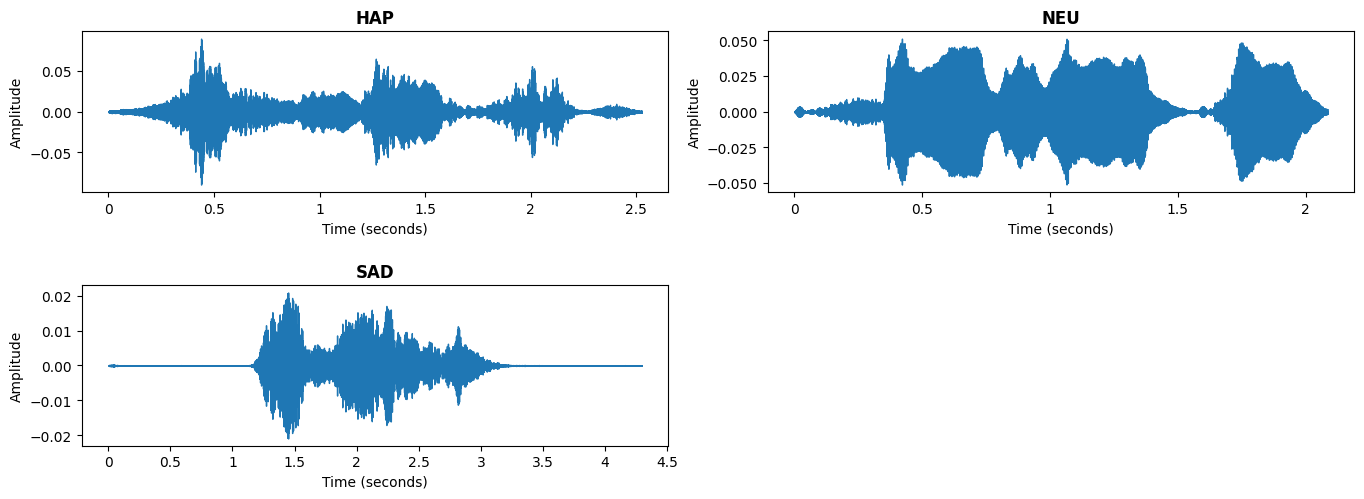

In [10]:
NUM_EMOTION = len(df['emotion'].unique())

sample = df.groupby('emotion', group_keys=False).apply(lambda x: x.sample(1))
sample_paths = sample['path'].tolist()
print(sample_paths)
plt.figure(figsize=(14, 10))
for i in range(NUM_EMOTION):
    plt.subplot(4, 2, i+1)
    data, sr = librosa.load(sample_paths[i], sr=SAMPLE_RATE)
    librosa.display.waveshow(data, sr=sr)
    plt.title(sample['emotion'].values[i], fontweight='bold')
    plt.ylabel('Amplitude')
    plt.xlabel('Time (seconds)')
plt.tight_layout(pad=2)


Create a function that extracts MFCCs from an audio file

In [ ]:
N_MFCC = 26          # MFCCs
N_FFT = 2048         # FFT Length
HOP_LENGTH = int(0.010 * SAMPLE_RATE)  # Hop Length: 10ms (~160 samples)
WIN_LENGTH = int(0.025 * SAMPLE_RATE)  # Window Length: 25ms (~400 samples)
N_MELS = 26          # Filterbanks
WINDOW = 'hamming'   # Window Function

def extract_mfcc(path):
    """
    Load an audio file, extract MFCC features, and return as a numpy array.
    """
    audio, sr = librosa.load(path, sr=SAMPLE_RATE, duration=3, mono=True)

    if len(audio) < 3 * sr:
        audio = np.pad(audio, pad_width=(0, 3 * sr - len(audio)), mode='constant')
    mfccs = librosa.feature.mfcc(
        y=audio, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT,
        hop_length=HOP_LENGTH, win_length=WIN_LENGTH,
        window=WINDOW, n_mels=N_MELS
    )

    return np.array(mfccs)


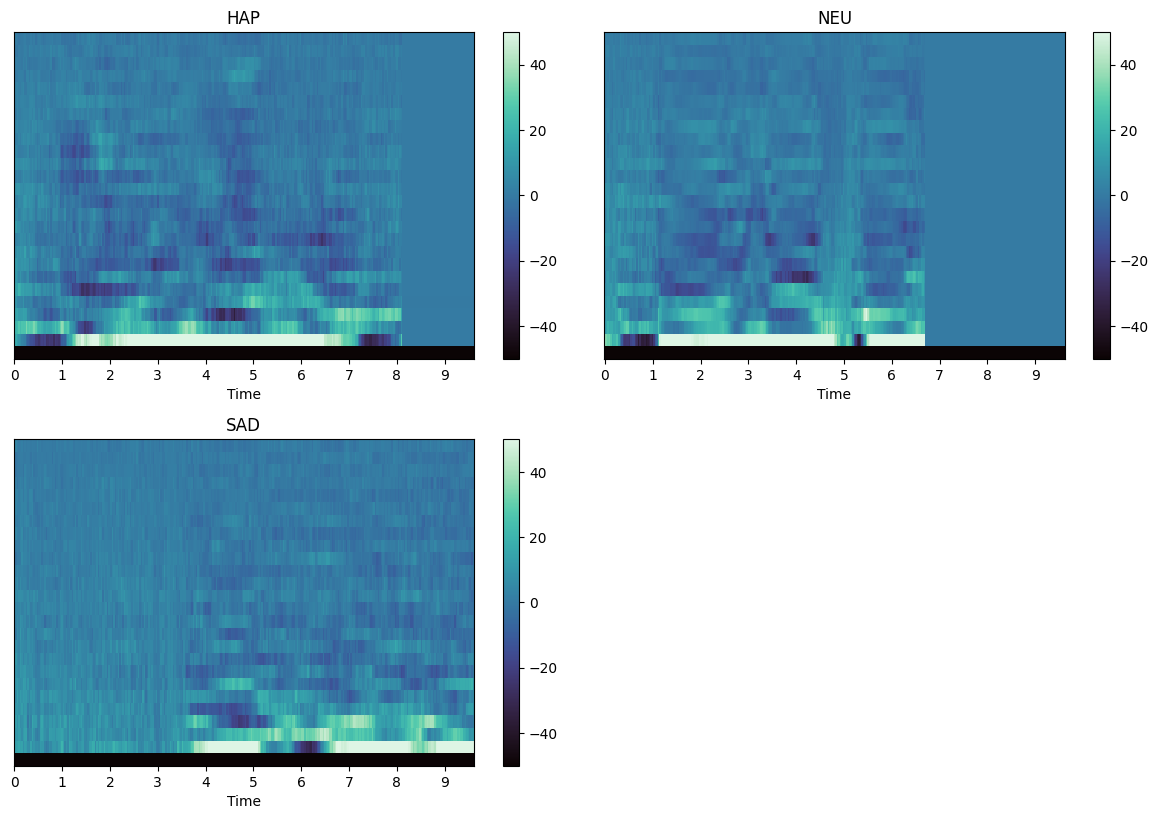

In [12]:
# Visualize the MFCCs for each emotion
plt.figure(figsize=(12, 16))
for i in range(3):
    plt.subplot(4, 2, i+1)
    # Extract the MFCCs from the audio file
    mfcc = extract_mfcc(sample_paths[i])
    librosa.display.specshow(mfcc, sr=sr, x_axis='time', cmap = 'mako', norm = Normalize( vmin = -50, vmax = 50))
    plt.title(sample['emotion'].values[i])
    plt.colorbar()
plt.tight_layout()

label encoding

In [13]:
encoder = LabelEncoder()
df['emotion'] = encoder.fit_transform(df['emotion'])
# Make sure the encoding worked
df['emotion'].value_counts()

,count
emotion,
0,12470
2,11855
1,11400


Divide the data into features and labels

In [14]:
X_mfcc = [extract_mfcc(path) for path in df['path']]
y_mfcc = df['emotion']

In [15]:
print('Number of images:', len(X_mfcc))
print('Number of labels:', len(y_mfcc))

Number of images: 35725
Number of labels: 35725


Label: 1


Text(0.5, 1.0, 'MFCC')

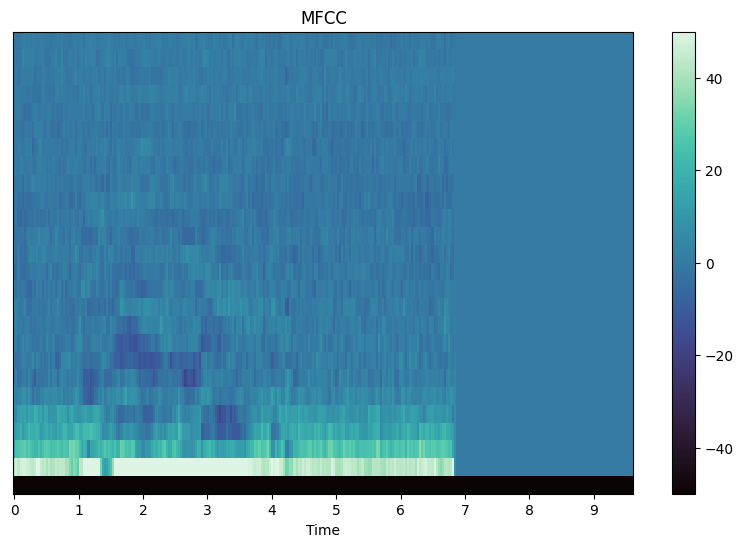

In [16]:
# Print the first image and its corresponding label
print('Label:', y_mfcc[0])
plt.figure(figsize=(10, 6))
librosa.display.specshow(X_mfcc[0], sr=sr, x_axis='time', cmap = 'mako', norm = Normalize( vmin = -50, vmax = 50))
plt.colorbar()
plt.title('MFCC')

In [17]:
# Divide the data into training and testing sets, with a 80:20 split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_mfcc, y_mfcc,test_size=0.2,random_state=42,shuffle=True)

In [18]:
# Check the length of the training and testing sets
print('Number of training images:', len(X_train_2))
print('Number of testing images:', len(X_test_2))
print('Number of training labels:', len(y_train_2))
print('Number of testing labels:', len(y_test_2))

Number of training images: 28580
Number of testing images: 7145
Number of training labels: 28580
Number of testing labels: 7145


In [19]:
# Convert the lists into numpy arrays
X_train_2 = np.array(X_train_2)
X_test_2 = np.array(X_test_2)
y_train_2 = np.array(y_train_2)
y_test_2 = np.array(y_test_2)
# Check the shape of the arrays
print('X_train shape:', X_train_2.shape)
print('X_test shape:', X_test_2.shape)
print('y_train shape:', y_train_2.shape)
print('y_test shape:', y_test_2.shape)

X_train shape: (28580, 26, 301)
X_test shape: (7145, 26, 301)
y_train shape: (28580,)
y_test shape: (7145,)


In [20]:
# Standardize the data by subtracting the mean and dividing by the standard deviation
mean = np.mean(X_train_2)
std = np.std(X_train_2)
X_train_2 = (X_train_2 - mean) / std
X_test_2 = (X_test_2 - mean) / std

In [21]:
# Check the mean and standard deviation
print('Mean:', mean)
print('Standard deviation:', std)
# Check if the data is standardized
print('Mean of standardized data:', np.mean(X_train_2))
print('Standard deviation of standardized data:', np.std(X_train_2))

Mean: -7.0426135
Standard deviation: 48.8516
Mean of standardized data: 4.0631042e-07
Standard deviation of standardized data: 1.0000004


In [22]:
X_train_2 = X_train_2.reshape(X_train_2.shape[0], 26, 301, 1)
X_test_2 = X_test_2.reshape(X_test_2.shape[0], 26, 301, 1)
# Check the shape of the arrays
print('X_train shape:', X_train_2.shape)
print('X_test shape:', X_test_2.shape)

X_train shape: (28580, 26, 301, 1)
X_test shape: (7145, 26, 301, 1)


In [23]:
# Divide the data into batches of 32 images
batch_size = 32
# Make a training dataset from the training set
train_dataset_2 = tf.data.Dataset.from_tensor_slices((X_train_2, y_train_2))
# Shuffle, batch, and prefetch the data
train_dataset_2 = train_dataset_2.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# Make a testing dataset from the testing set
test_dataset_2 = tf.data.Dataset.from_tensor_slices((X_test_2, y_test_2))
# Shuffle, batch, and prefetch the data
test_dataset_2 = test_dataset_2.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

#### Define the CNN model

In [ ]:

model_mfcc = tf.keras.Sequential([
    # First convolutional layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(26, 301, 1), padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # Batch normalization maintains the 0 mean and 1 standard deviation
    tf.keras.layers.BatchNormalization(),
    # Second convolutional layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    # Third convolutional layer
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    # Global average pooling layer averages the values in each feature map into a single value
    tf.keras.layers.GlobalAveragePooling2D(),
    # Dropout layer randomly sets 50% of the activations to zero
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_EMOTION, activation='softmax')
])

In [45]:
model_mfcc.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 26, 301, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 13, 150, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 13, 150, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 13, 150, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 75, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 6, 75, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 6, 75, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 3, 37, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 3, 37, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 280,971 (1.07 MB)

 Trainable params: 93,507 (365.26 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 187,016 (730.54 KB)

In [29]:
# Compile the model
model_mfcc.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

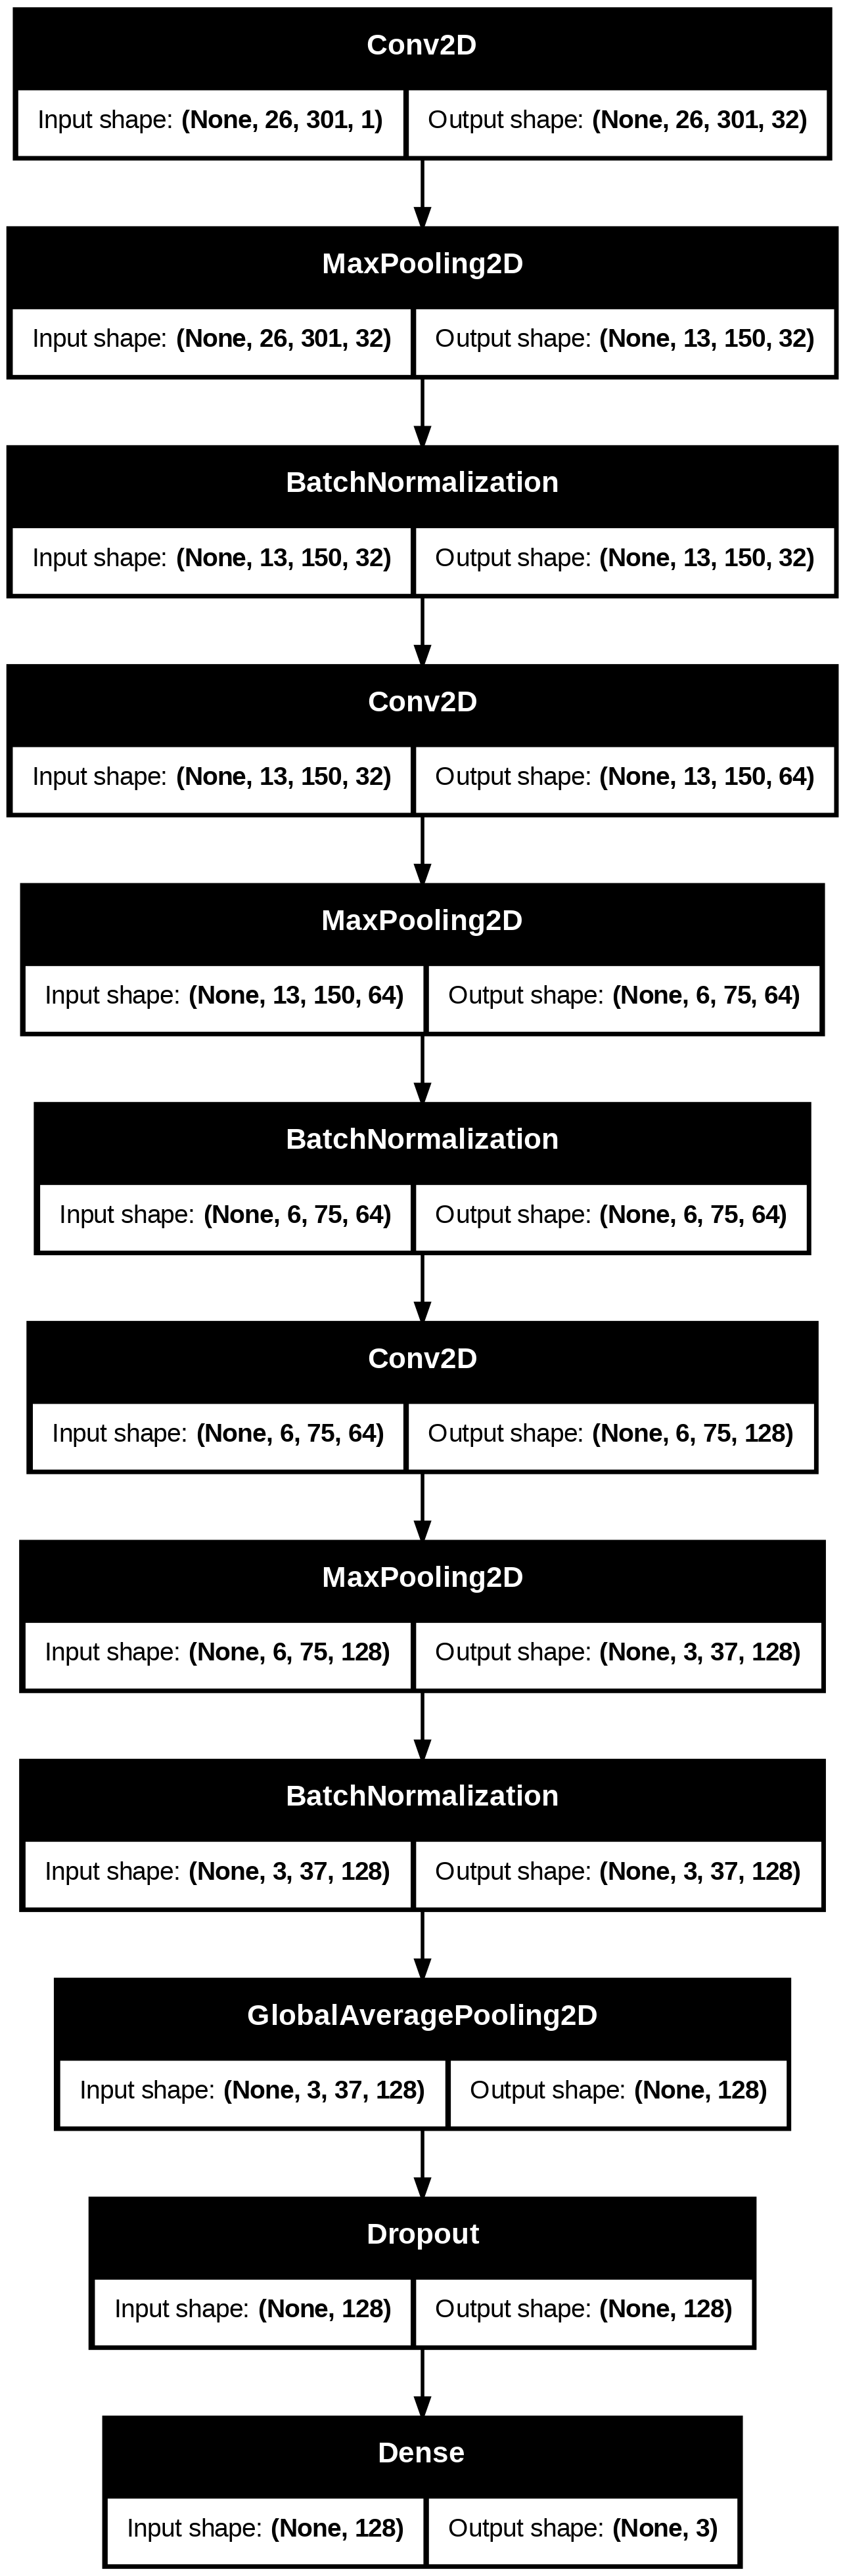

In [30]:
# Plot the model architecture
tf.keras.utils.plot_model(model_mfcc, show_shapes=True, to_file='model_mfcc.png')

In [31]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    mode='min',
    verbose=1
)


lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=5e-6,
    cooldown=2,
    verbose=1,
    mode='min'
)


checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# fit the model
history_mfcc = model_mfcc.fit(train_dataset_2,
                    epochs=50,
                    validation_data=test_dataset_2,
                    callbacks=[early_stop, lr_scheduler, checkpoint])

Epoch 1/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5771 - loss: 0.9082
Epoch 1: val_loss improved from inf to 1.32969, saving model to best_model.h5


894/894 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.5772 - loss: 0.9081 - val_accuracy: 0.4689 - val_loss: 1.3297 - learning_rate: 0.0010
Epoch 2/50
893/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6938 - loss: 0.7177
Epoch 2: val_loss did not improve from 1.32969
894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6938 - loss: 0.7176 - val_accuracy: 0.5038 - val_loss: 1.3953 - learning_rate: 0.0010
Epoch 3/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7178 - loss: 0.6632
Epoch 3: val_loss did not improve from 1.32969
894/894 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7178 - loss: 0.6632 - val_accuracy: 0.3945 - val_loss: 2.1287 - learning_rate: 0.0010
Epoch 4/50
890/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7386 - loss: 0.6204
Epoch 4: val_loss improved from 1.32969 to 0.74482, saving model to best_model.h5


894/894 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7386 - loss: 0.6204 - val_accuracy: 0.6816 - val_loss: 0.7448 - learning_rate: 0.0010
Epoch 5/50
889/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7505 - loss: 0.5930
Epoch 5: val_loss did not improve from 0.74482
894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7505 - loss: 0.5929 - val_accuracy: 0.6021 - val_loss: 0.9628 - learning_rate: 0.0010
Epoch 6/50
892/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7624 - loss: 0.5686
Epoch 6: val_loss improved from 0.74482 to 0.70748, saving model to best_model.h5


894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7624 - loss: 0.5685 - val_accuracy: 0.6894 - val_loss: 0.7075 - learning_rate: 0.0010
Epoch 7/50
892/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7767 - loss: 0.5440
Epoch 7: val_loss did not improve from 0.70748
894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7767 - loss: 0.5440 - val_accuracy: 0.6887 - val_loss: 0.7286 - learning_rate: 0.0010
Epoch 8/50
890/894 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7840 - loss: 0.5301
Epoch 8: val_loss did not improve from 0.70748
894/894 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7840 - loss: 0.5300 - val_accuracy: 0.6328 - val_loss: 0.8979 - learning_rate: 0.0010
Epoch 9/50
893/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7961 - loss: 0.5027
Epoch 9: val_loss improved from 0.70748 to 0.57259, saving model to best_model.h5


894/894 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7961 - loss: 0.5027 - val_accuracy: 0.7639 - val_loss: 0.5726 - learning_rate: 0.0010
Epoch 10/50
888/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7967 - loss: 0.4942
Epoch 10: val_loss did not improve from 0.57259
894/894 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7968 - loss: 0.4941 - val_accuracy: 0.7232 - val_loss: 0.6218 - learning_rate: 0.0010
Epoch 11/50
892/894 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8068 - loss: 0.4785
Epoch 11: val_loss did not improve from 0.57259
894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8068 - loss: 0.4784 - val_accuracy: 0.5290 - val_loss: 1.5953 - learning_rate: 0.0010
Epoch 12/50
888/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8152 - loss: 0.4608
Epoch 12: val_loss improved from 0.57259 to 0.45498, saving model to best_model.h5


894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8152 - loss: 0.4607 - val_accuracy: 0.8209 - val_loss: 0.4550 - learning_rate: 0.0010
Epoch 13/50
889/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8184 - loss: 0.4429
Epoch 13: val_loss did not improve from 0.45498
894/894 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8184 - loss: 0.4429 - val_accuracy: 0.7723 - val_loss: 0.5722 - learning_rate: 0.0010
Epoch 14/50
893/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8251 - loss: 0.4292
Epoch 14: val_loss improved from 0.45498 to 0.42482, saving model to best_model.h5


894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8251 - loss: 0.4292 - val_accuracy: 0.8351 - val_loss: 0.4248 - learning_rate: 0.0010
Epoch 15/50
889/894 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8333 - loss: 0.4167
Epoch 15: val_loss did not improve from 0.42482
894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8333 - loss: 0.4167 - val_accuracy: 0.8276 - val_loss: 0.4363 - learning_rate: 0.0010
Epoch 16/50
891/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8386 - loss: 0.3979
Epoch 16: val_loss did not improve from 0.42482
894/894 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8386 - loss: 0.3979 - val_accuracy: 0.7944 - val_loss: 0.4663 - learning_rate: 0.0010
Epoch 17/50
891/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8432 - loss: 0.3915
Epoch 17: val_loss improved from 0.42482 to 0.39159, saving model to best_model.h5


894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8432 - loss: 0.3915 - val_accuracy: 0.8497 - val_loss: 0.3916 - learning_rate: 0.0010
Epoch 18/50
890/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8484 - loss: 0.3760
Epoch 18: val_loss did not improve from 0.39159
894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8484 - loss: 0.3760 - val_accuracy: 0.8441 - val_loss: 0.3986 - learning_rate: 0.0010
Epoch 19/50
890/894 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8487 - loss: 0.3699
Epoch 19: val_loss did not improve from 0.39159
894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8488 - loss: 0.3699 - val_accuracy: 0.7772 - val_loss: 0.5764 - learning_rate: 0.0010
Epoch 20/50
888/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8565 - loss: 0.3568
Epoch 20: val_loss did not improve from 0.39159
894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8565 - loss: 0.3568 - val_accuracy: 0.8223 - val_loss: 0.4647 - learning_rate: 0.0010
Epoch 21/50
889/894 ━

894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8879 - loss: 0.2863 - val_accuracy: 0.8654 - val_loss: 0.3420 - learning_rate: 5.0000e-04
Epoch 24/50
888/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8903 - loss: 0.2776
Epoch 24: val_loss did not improve from 0.34197
894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8903 - loss: 0.2775 - val_accuracy: 0.8655 - val_loss: 0.3477 - learning_rate: 5.0000e-04
Epoch 25/50
890/894 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8967 - loss: 0.2695
Epoch 25: val_loss did not improve from 0.34197
894/894 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8967 - loss: 0.2695 - val_accuracy: 0.8628 - val_loss: 0.3610 - learning_rate: 5.0000e-04
Epoch 26/50
892/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9025 - loss: 0.2546
Epoch 26: val_loss did not improve from 0.34197
894/894 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9025 - loss: 0.2546 - val_accuracy: 0.8599 - val_loss: 0.3462 - learning_rate: 5.0000e-04
Epoch 2

894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9105 - loss: 0.2330 - val_accuracy: 0.8687 - val_loss: 0.3314 - learning_rate: 2.5000e-04
Epoch 29/50
892/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9190 - loss: 0.2184
Epoch 29: val_loss improved from 0.33143 to 0.31462, saving model to best_model.h5


894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9190 - loss: 0.2184 - val_accuracy: 0.8789 - val_loss: 0.3146 - learning_rate: 2.5000e-04
Epoch 30/50
892/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9178 - loss: 0.2120
Epoch 30: val_loss did not improve from 0.31462
894/894 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9178 - loss: 0.2120 - val_accuracy: 0.8823 - val_loss: 0.3168 - learning_rate: 2.5000e-04
Epoch 31/50
894/894 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9189 - loss: 0.2107
Epoch 31: val_loss did not improve from 0.31462
894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9189 - loss: 0.2107 - val_accuracy: 0.8718 - val_loss: 0.3367 - learning_rate: 2.5000e-04
Epoch 32/50
890/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9241 - loss: 0.1994
Epoch 32: val_loss did not improve from 0.31462
894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9241 - loss: 0.1994 - val_accuracy: 0.8801 - val_loss: 0.3160 - learning_rate: 2.5000e-04
Epoc

894/894 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9271 - loss: 0.1944 - val_accuracy: 0.8806 - val_loss: 0.3103 - learning_rate: 2.5000e-04
Epoch 34/50
893/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9256 - loss: 0.1939
Epoch 34: val_loss did not improve from 0.31029
894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9256 - loss: 0.1938 - val_accuracy: 0.8662 - val_loss: 0.3448 - learning_rate: 2.5000e-04
Epoch 35/50
892/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9312 - loss: 0.1885
Epoch 35: val_loss did not improve from 0.31029
894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9312 - loss: 0.1885 - val_accuracy: 0.8773 - val_loss: 0.3390 - learning_rate: 2.5000e-04
Epoch 36/50
892/894 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9285 - loss: 0.1888
Epoch 36: val_loss did not improve from 0.31029
894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9285 - loss: 0.1888 - val_accuracy: 0.8802 - val_loss: 0.3144 - learning_rate: 2.5000e-04
Epoch 

894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9378 - loss: 0.1650 - val_accuracy: 0.8892 - val_loss: 0.2996 - learning_rate: 1.2500e-04
Epoch 40/50
888/894 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9408 - loss: 0.1590
Epoch 40: val_loss did not improve from 0.29959
894/894 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9408 - loss: 0.1589 - val_accuracy: 0.8808 - val_loss: 0.3193 - learning_rate: 1.2500e-04
Epoch 41/50
889/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9388 - loss: 0.1639
Epoch 41: val_loss did not improve from 0.29959
894/894 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9388 - loss: 0.1639 - val_accuracy: 0.8861 - val_loss: 0.3059 - learning_rate: 1.2500e-04
Epoch 42/50
889/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9421 - loss: 0.1569
Epoch 42: val_loss did not improve from 0.29959
894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9421 - loss: 0.1569 - val_accuracy: 0.8833 - val_loss: 0.3100 - learning_rate: 1.2500e-04
Epoch 

894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9465 - loss: 0.1487 - val_accuracy: 0.8894 - val_loss: 0.2971 - learning_rate: 6.2500e-05
Epoch 45/50
893/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9460 - loss: 0.1484
Epoch 45: val_loss did not improve from 0.29711
894/894 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9460 - loss: 0.1484 - val_accuracy: 0.8894 - val_loss: 0.2984 - learning_rate: 6.2500e-05
Epoch 46/50
893/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9422 - loss: 0.1519
Epoch 46: val_loss did not improve from 0.29711
894/894 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9422 - loss: 0.1519 - val_accuracy: 0.8889 - val_loss: 0.2982 - learning_rate: 6.2500e-05
Epoch 47/50
889/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9461 - loss: 0.1449
Epoch 47: val_loss did not improve from 0.29711
894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9461 - loss: 0.1449 - val_accuracy: 0.8880 - val_loss: 0.2976 - learning_rate: 6.2500e-05
Epoch

894/894 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9450 - loss: 0.1476 - val_accuracy: 0.8901 - val_loss: 0.2962 - learning_rate: 3.1250e-05
Epoch 50/50
892/894 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9468 - loss: 0.1416
Epoch 50: val_loss did not improve from 0.29623
894/894 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9468 - loss: 0.1416 - val_accuracy: 0.8882 - val_loss: 0.2972 - learning_rate: 3.1250e-05
Restoring model weights from the end of the best epoch: 49.


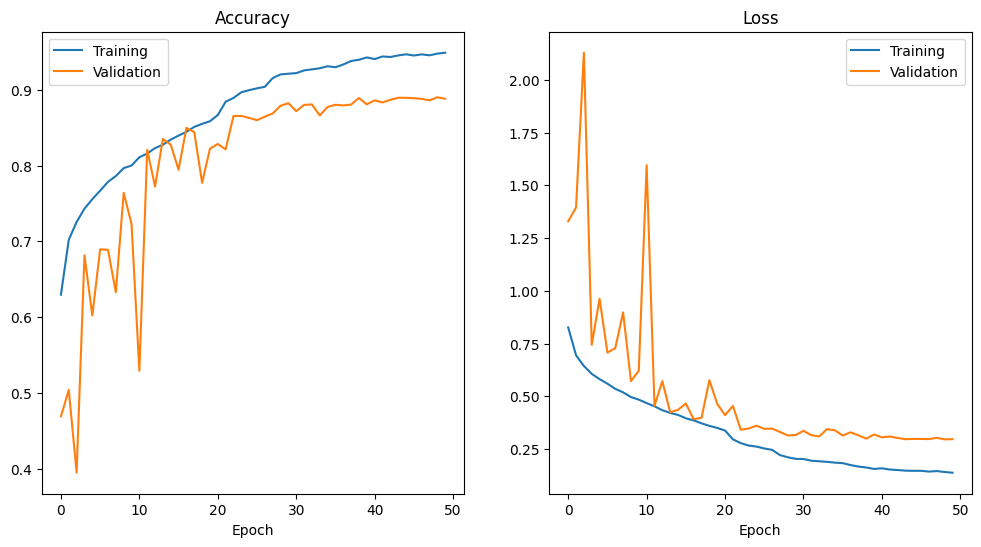

In [35]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_mfcc.history['accuracy'], label='Training')
plt.plot(history_mfcc.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_mfcc.history['loss'], label='Training')
plt.plot(history_mfcc.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

In [37]:
# Measure the precision and recall
y_pred = model_mfcc.predict(X_test_2)
# Convert the predictions into one-hot encoded vectors
y_pred = np.argmax(y_pred, axis=1)
# Plot the classification report
print(classification_report(y_test_2, y_pred, target_names=encoder.classes_))

224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
              precision    recall  f1-score   support

         HAP       0.93      0.92      0.92      2494
         NEU       0.86      0.88      0.87      2321
         SAD       0.88      0.88      0.88      2330

    accuracy                           0.89      7145
   macro avg       0.89      0.89      0.89      7145
weighted avg       0.89      0.89      0.89      7145



224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


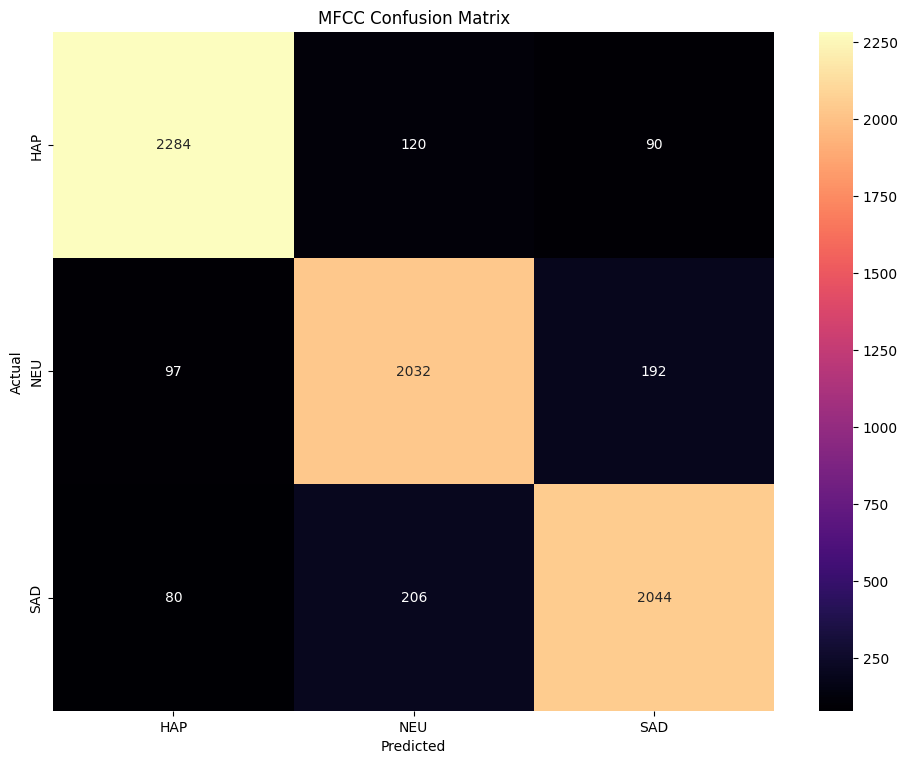

In [39]:
# Plot the confusion matrix for the validation set
# Get the predictions for the test data
y_pred = model_mfcc.predict(X_test_2)
# Convert the predictions into one-hot encoded vectors
y_pred = np.argmax(y_pred, axis=1)
# Get the confusion matrix
cm = tf.math.confusion_matrix(y_test_2, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
# Make the index and column labels the emotion names
cm = pd.DataFrame(cm.numpy(), index=encoder.classes_, columns=encoder.classes_)
sns.heatmap(cm, annot=True, fmt='', cmap='magma')
plt.title('MFCC Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout(pad=2)

In [36]:
loss, accuracy = model_mfcc.evaluate(X_test_2, y_test_2)
print(f"Test Accuracy: {accuracy:.4f}")

224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8854 - loss: 0.3009
Test Accuracy: 0.8901


In [ ]:
model_mfcc.save("model_mfcc.keras")

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_mfcc)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_mfcc = converter.convert()

with open("model_lite_mfcc.tflite", "wb") as f:
    f.write(tflite_model_mfcc)

Saved artifact at '/tmp/tmpjzf5xvcf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 26, 301, 1), dtype=tf.float32, name='keras_tensor_16')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135769264078480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135769264075024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135769264075216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135769264074448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135769264076176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135769264074832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135769264074064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135769264071952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135769264072144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135769264073680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135769264076

In [34]:
!xxd -i model_lite_mfcc.tflite > emotion_recognition_mfcc.h

#### Predict

In [ ]:
def predict_audio(file_path, model_path="model_mfcc.keras"):
    """
    Predicts the emotion from an audio file using a trained Keras model.

    Args:
        file_path: Path to the audio file.
        model_path: Path to the saved Keras model.

    Returns:
        The predicted emotion label.
    """
    try:
        # Load the pre-trained model
        model = tf.keras.models.load_model(model_path)

        # Parameters for MFCC extraction (ensure these match training parameters)
        SAMPLE_RATE = 16000
        N_MFCC = 40
        N_FFT = 2048
        HOP_LENGTH = int(0.010 * SAMPLE_RATE)
        WIN_LENGTH = int(0.025 * SAMPLE_RATE)
        N_MELS = 26
        WINDOW = 'hamming'

        def extract_mfcc(path):
          audio, sr = librosa.load(path, sr=SAMPLE_RATE, duration=3, mono=True)
          if len(audio) < 3 * sr:
              audio = np.pad(audio, pad_width=(0, 3 * sr - len(audio)), mode='constant')
          mfccs = librosa.feature.mfcc(
              y=audio, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT,
              hop_length=HOP_LENGTH, win_length=WIN_LENGTH,
              window=WINDOW, n_mels=N_MELS
          )
          return np.array(mfccs)

        # Extract MFCCs from the input audio file
        mfccs = extract_mfcc(file_path)
        # Mean: -7.0426135
        # Standard deviation: 48.8516
        # Mean of standardized data: 4.0631042e-07
        # Standard deviation of standardized data: 1.0000004
        # Preprocess the MFCCs (same preprocessing as during training)
        mean = -7.0426135
        std = 48.8516
        mfccs = (mfccs - mean) / std
        mfccs = mfccs.reshape(1, 26, 301, 1)
        predictions = model.predict(mfccs)
        predicted_class = np.argmax(predictions)
        # Emotion labels
        emotion_labels = ["HAP", "NEU", "SAD"]
        predicted_emotion = emotion_labels[predicted_class]
        return predicted_emotion
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None


# file_to_predict = "/content/Predict/1091_SAD_WSI_XX.wav"
# predicted_label = predict_audio(file_to_predict)

# if predicted_label:
#     print(f"The predicted emotion for {file_to_predict} is: {predicted_label}")


def predict_all_in_directory(directory_path):
    for filename in os.listdir(directory_path):
        if filename.endswith(".wav"):
            file_path = os.path.join(directory_path, filename)
            predicted_label = predict_audio(file_path)

            if predicted_label:
                print(f"The predicted emotion for {filename} is: {predicted_label}")
            else:
                print(f"Prediction failed for {filename}")

directory_to_predict = "/content/Predict"
predict_all_in_directory(directory_to_predict)